# Model-building phase
- [Data Preprocessing](#Data-Preprocessing)
- [Supervised Models](#Supervised-Models)
    - [Random Forest](#Random-Forest)
    - [Gradient Boosting](#Gradient-Boosting)
    - [Perceptron](#Perceptron)
    - [SVM](#Support-Vector-Machines-(SVM))
- [Unsupervised Models](#Unsupervised-Models)


In [54]:
import pandas as pd
import numpy as np
import random
from tools import *
from pprint import pprint
import pickle

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from  sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

## Data Preprocessing

In preprocessing the data we make use of the *prep* function, which simultaneously allows us both to deal with the missing values, giving us the choice of removing them, or partially removing them by replacing the remainder with the mean or median of the corresponding variable, and to scale the data, with the possibility of choosing the method by which to scale such data from all the scalers in scikit-learn, by default the MinMaxScaler is set. The function then takes as input a pandas DataFrame and outputs a numpy ndarray containing the cleaned data from the previous dataset.

Our idea is to generate two datasets: the first by eliminating all observations having at least one component with a missing value, the second by eliminating only 50 percent of those observations. Eventually we will train each model using both datasets and collect their metrics in order to assess whether on average such a reduction in missing values to be eliminated (thus replacing the missing part) resulted in any benefit.

### Scaling Data
To observe if there are difference in performance of the models  trained on a dataset with  all the Nan values imputed and in the models trained on a dataset with only a percentage of Nan values imputed, we have  created 2 dataset:
- one where we imputed all the Nan values (Water 100 dataset)
- one where we imputed only the half Nan values deleting the remain part of observations (Water 50 dataset)

In [4]:
random_seed = 42

In [5]:
# Setting random state for each model
water = pd.read_csv('dataset/drinking_water_potability.csv')
water50 = prep(
    data = water,
    target='Potability',
    axis='obs',
    perc=50,
    fill_method='mean',
    scaler= StandardScaler(),
    random_state = random_seed
)
water100 = prep(
    data = water,
    target='Potability',
    axis='obs',
    perc=0,
    fill_method='mean',
    scaler= StandardScaler(),
    random_state = random_seed
)
print('original dataset size: ', water.shape, '- type: ', type(water))
print('cleaned dataset with 50% of missing values removed: ', np.shape(water50), '- type: ', type(water50))
print('cleaned dataset with no missing values removed: ', np.shape(water100), '- type: ', type(water100))

original dataset size:  (3276, 10) - type:  <class 'pandas.core.frame.DataFrame'>
cleaned dataset with 50% of missing values removed:  (2644, 10) - type:  <class 'numpy.ndarray'>
cleaned dataset with no missing values removed:  (3276, 10) - type:  <class 'numpy.ndarray'>


### Splitting Data
At this point we proceed to divide the dataset into train set, validation set and test set. To do this, we make use of the *train_test_split()* function of scikit-learn.

In [6]:
#Water 50
X_train50, X_val50, X_test50, y_train50, y_val50, y_test50=split(df = water50,
                                                                 target_index = 9,
                                                                 validation = True,
                                                                 perc_train = 0.7,
                                                                 random_seed = random_seed,
                                                                 verbose=True
                                                                )

BEFORE SPLITTING: 

X shape:  (2644, 9)
y shape:  (2644,)

AFTER SPLITTING: 
X_train shape:  (1850, 9)
y_train shape:  (1850,)
X_test shape:  (794, 9)
y_test shape:  (794,)
X_val shape:  (397, 9)
y_val shape:  (397,)


In [7]:
#Water 100
X_train100, X_val100, X_test100, y_train100, y_val100, y_test100=split(df = water100,
                                                                       target_index = 9,
                                                                       perc_train = 0.7,
                                                                       random_seed = random_seed,
                                                                       verbose=True
                                                                       )

BEFORE SPLITTING: 

X shape:  (3276, 9)
y shape:  (3276,)

AFTER SPLITTING: 
X_train shape:  (2293, 9)
y_train shape:  (2293,)
X_test shape:  (983, 9)
y_test shape:  (983,)
X_val shape:  (491, 9)
y_val shape:  (491,)


## Supervised Models
The Supervised models that we chose are the following:
- **Random Forest**
- **XGBoost**
- **Support Vector Machine**
- **K-Nearest Neighbours**

In this part of the report we will train the above models reported  on Water100 dataset, that one with all the Nan values imputed.


### **Random Forest** <a name="random-forest"></a>

Random forest or random decision forest is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. 

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)



#### Random Forest Base Model
First of all we will train the base model to have a starting to compare

In [24]:
# Training base model
rf_base = RandomForestClassifier(random_state = random_seed)
rf_base.fit(X_train100, y_train100)
#Computing the base model accuracy
rf_base_metrics = evaluate(rf_base, X_val100, y_val100)

Model Performance: 

accuracy = 80.04%.
recall = 58.01%.
precision = 82.68%.
f1_score = 68.18%.


#### Random Search with Cross Validation
Here we will try to search the best configuration of hyperparameters with a random search, choosing among thousand combinations of hyperparameters only 100 random combinations, after this first step we will focus using a grid search around the combinations found with the random search

In [8]:
#Defining Random Forest Claasifier
rf = RandomForestClassifier(random_state = random_seed)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
rf.get_params()

Parameters currently in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


As we can see there are many hyperparameters that we can tune, below we chose the most importants

In [9]:
random_grid = {
    # Number of trees in random forest
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    # Number of features to consider at every split
    'max_features': ['auto', 'sqrt','log2', None],
    # Maximum number of levels in tree
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    # Minimum number of samples required to split a node
    'min_samples_split': [2, 5, 10],
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': [1, 2, 4],
    # Method of selecting samples for training each tree
    'bootstrap': [True, False],
    # Metrics  to measure the quality of a split.
    'criterion':['gini', 'entropy', 'log_loss']
}

pprint(random_grid)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy', 'log_loss'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Actually if we used all the possible combinations we should train the random forest 25920 times without considering the cross validation for each combinations, that would require a computational time too high, for this reason initially we will use the random search using only 100 random combinations among those available

In [10]:
rf_random_search = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid,
    n_iter = 100, 
    cv = 3, 
    random_state=random_seed, 
    n_jobs = -1
    )

#rf_random.fit(X_train100, y_train100)

##### Storing and Loading Models
To avoid  traininig each time the models we will save after every training of the models the results inside *Models folder* using pickle library


In [11]:
#pickle.dump(rf_random_search, open('Models/Random_Forest_rs_w100.pkl', 'wb'))
rf_random_search=pickle.load(open('Models/Random_Forest_rs_w100.pkl', 'rb'))

In [12]:
rf_random_search.best_params_

{'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'log_loss',
 'bootstrap': True}

##### Comparing base model with tuned model with Random Search
To check if we are going in  the right direction, we will compare the metrics obtained from the base model  with the metrics of the tuned model 

In [22]:
# Training tuned model
rf_random =  RandomForestClassifier(bootstrap = True,
                                    criterion='log_loss',
                                    max_depth=10,
                                    max_features='auto',
                                    min_samples_leaf=1,
                                    min_samples_split=10,
                                    n_estimators=1400,
                                    random_state=random_seed
                                    )

rf_random.fit(X_train100,y_train100)

C:\Users\pepee\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(criterion='log_loss', max_depth=10, max_features='auto',
                       min_samples_split=10, n_estimators=1400,
                       random_state=42)

As we can see, tuning the Random Forest we gained an increment in accuracy of 0.51%.Now we will tune the Random Forest again around the hyperparameters reported by random search.

Confusion matrix: 


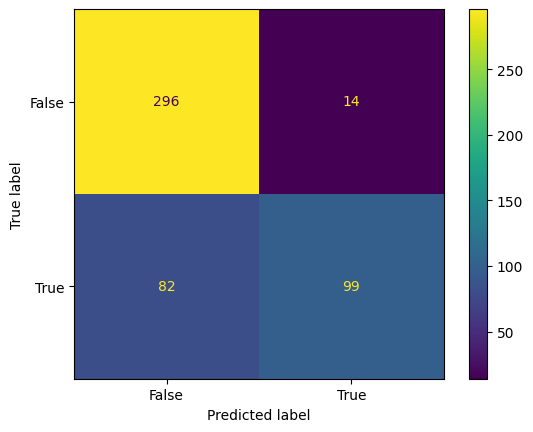

Model Performance: 

accuracy = 80.45%.
recall = 54.70%.
precision = 87.61%.
f1_score = 67.35%.
The tuned model had an improvement of 0.51%. respect the base model


In [25]:
#Computing the tuned model accuracy                                 
rf_random_metrics = evaluate(rf_random, X_val100, y_val100,conf_matrix=True)

print('The tuned model had an improvement of {:0.2f}%. respect the base model'
        .format( 100 * (rf_random_metrics[0] - rf_base_metrics[0]) / rf_base_metrics[0]))


#### Grid Search with Cross Validation
Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [14]:
#Defining Random Forest Claasifier
rf = RandomForestClassifier(random_state = random_seed)

In [15]:
rf_random_search.best_params_

{'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'log_loss',
 'bootstrap': True}

In [16]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'criterion':['log_loss'],
    'max_depth': [5,10,15],
    'max_features': ['auto'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [5,10,15],
    'n_estimators': [1300,1400,1500]
}
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 5, n_jobs = -1, verbose = 1)
# Fit the grid search to the data
#rf_grid_search.fit(X_train100, y_train100)

##### Saving and loading the model

In [17]:
#pickle.dump(rf_random, open('Models/Random_Forest_rs_w100.pkl', 'wb'))
rf_grid_search = pickle.load(open('Models/Random_Forest_gs_w100.pkl', 'rb'))

In [18]:
rf_grid_search.best_params_

{'bootstrap': True,
 'criterion': 'log_loss',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 1500}

##### Comparing base model with tuned model with Grid Search
Also this time to check that we are going in right direction we will compare the metrics obtained from base model  with the metrics of the  tuned model.

In [26]:
# Training tuned model
rf_final =  RandomForestClassifier(bootstrap = True,
                                   criterion='log_loss',
                                   max_depth=10,
                                   max_features='auto',
                                   min_samples_leaf=2,
                                   min_samples_split=15,
                                   n_estimators=1500,
                                   random_state=random_seed
                                   )
                                   
rf_final.fit(X_train100,y_train100)

C:\Users\pepee\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(criterion='log_loss', max_depth=10, max_features='auto',
                       min_samples_leaf=2, min_samples_split=15,
                       n_estimators=1500, random_state=42)

Confusion matrix: 


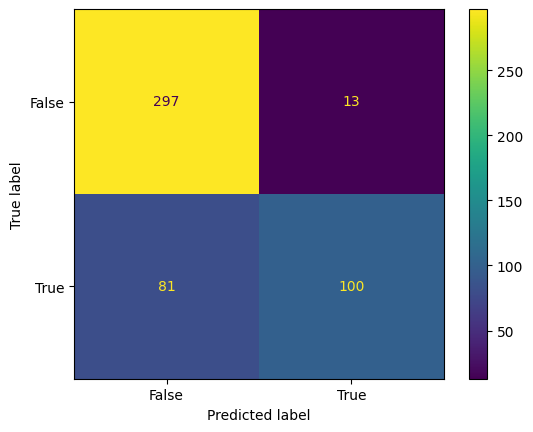

Model Performance: 

accuracy = 80.86%.
recall = 55.25%.
precision = 88.50%.
f1_score = 68.03%.
The tuned model with grid search had an improvement of 1.02%. respect the base model
The tuned model with grid search had an improvement of 0.51%. respect the tuned  model with random search


In [27]:
#Computing the tuned model accuracy                                 
rf_grid_metrics = evaluate(rf_final, X_val100, y_val100,conf_matrix=True)

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the base model'
                        .format( 100 * (rf_grid_metrics[0] - rf_base_metrics[0]) / rf_base_metrics[0]))

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the tuned  model with random search'
                        .format( 100 * (rf_grid_metrics[0] - rf_random_metrics[0]) / rf_random_metrics[0]))

Hence, tuning phase allowed us to obtain an increase in accuracy respect the base model of **1.02%**.We could still continue to verify if there are better combinations of hyperparameters, but since that this is only an accademic report we will stop here with the tuning phase

### Gradient Boosting

In boosting, the individual models are not built on completely random subsets of data and features but sequentially by putting more weight on instances with wrong predictions and high errors. The general idea behind this is that instances, which are hard to predict correctly (“difficult” cases) will be focused on during learning, so that the model learns from past mistakes. When we train each ensemble on a subset of the training set, we also call this Stochastic Gradient Boosting, which can help improve generalizability of our model.The gradient is used to minimize a loss function, similar to how Neural Nets utilize gradient descent to optimize (“learn”) weights. 

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Confusion matrix: 


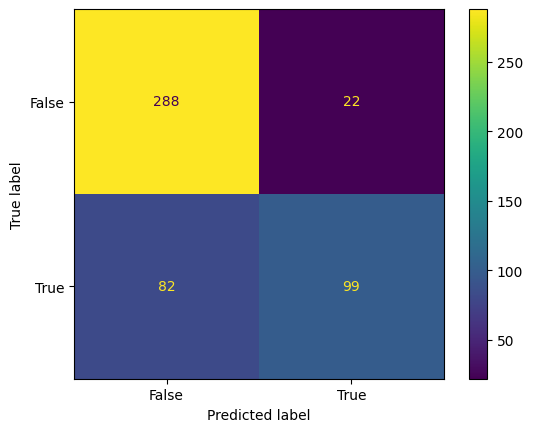

Model Performance: 

accuracy = 78.82%.
recall = 54.70%.
precision = 81.82%.
f1_score = 65.56%.


In [38]:
# Training base model
gb_base = GradientBoostingClassifier( random_state = random_seed)
gb_base.fit(X_train100, y_train100)
#Computing the base model accuracy
gb_base_metrics= evaluate(gb_base, X_val100, y_val100,conf_matrix=True)

### Random Search with Cross Validation

In [29]:
#Defining Random Forest Claasifier
gb = GradientBoostingClassifier(random_state = random_seed)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(gb.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [32]:
# Create the random grid
params_grid = {# The loss function to be optimized.
               'loss': ['log_loss','exponential'],
               # Learning rate shrinks the contribution of each tree by learning_rate
               'learning_rate':[0.001,0.01,0.1],
               # Number of trees in random forest
               'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]+[None],
               # Number of features to consider at every split
               'max_features': ['auto', 'sqrt','log2',None],
               # Maximum number of levels in tree
               'max_depth':  [int(x) for x in np.linspace(10, 110, num = 11)]+[None],
               # Minimum number of samples required to split a node
               'min_samples_split': [2, 5, 10],
               # Minimum number of samples required at each leaf node
               'min_samples_leaf': [1, 2, 4],
               # Metrics  to measure the quality of a split.
               'criterion':['friedman_mse','squared_error']}
pprint(params_grid)


{'criterion': ['friedman_mse', 'squared_error'],
 'learning_rate': [0.001, 0.01, 0.1],
 'loss': ['log_loss', 'exponential'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, None]}


Actually if we used all the possible combinations we should train the Gradient Boosting 103000 times without considering the cross validation for each combinations, that would require a computational time too high, for this reason initially we will use the random search using only 100 random combinations among those available

In [33]:
# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
gb_random_search = RandomizedSearchCV(estimator = gb, 
                                      param_distributions = params_grid,
                                      n_iter = 100, 
                                      cv = 3, 
                                      verbose=3, 
                                      random_state=random_seed, 
                                      n_jobs = -1)

#gb_random_search.fit(X_train100, y_train100)

#### Storing and Loading Models


In [34]:
#Saving
#pickle.dump(gb_random_search.best_params_, open('Models/Gradient_Boosting_rs_w100.pkl', 'wb'))
#Loading
gb_params_best_random=pickle.load(open('Models/Gradient_Boosting_rs_w100.pkl', 'rb'))

In [25]:
gb_params_best_random

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'loss': 'exponential',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

#### Comparing base model with tuned model with Random Search

In [35]:
# Training tuned model
gb_random =  GradientBoostingClassifier(loss='exponential',
                                        max_depth=20,
                                        max_features='sqrt',
                                        min_samples_leaf=1,
                                        min_samples_split=2,
                                        n_estimators=1600,
                                        learning_rate=0.01,
                                        criterion='friedman_mse',
                                        random_state=random_seed
                                        )
gb_random.fit(X_train100,y_train100)

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=20,
                           max_features='sqrt', n_estimators=1600,
                           random_state=42)

Confusion matrix: 


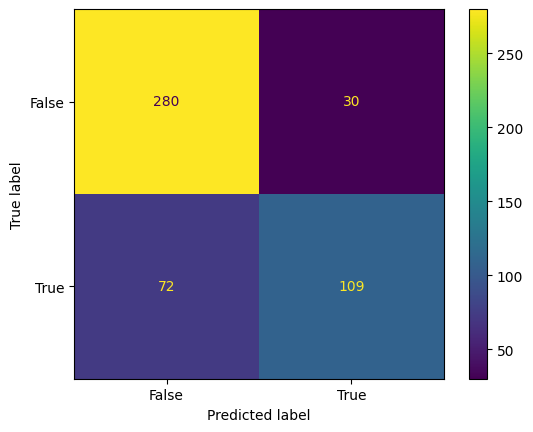

Model Performance: 

accuracy = 79.23%.
recall = 60.22%.
precision = 78.42%.
f1_score = 68.12%.
The tuned model with random search had an improvement of 0.52%. respect the base model


In [39]:
#Computing the tuned model accuracy                                 
gb_random_metrics= evaluate(gb_random, X_val100, y_val100,conf_matrix=True)

print('The tuned model with random search had an improvement of {:0.2f}%. respect the base model'
                        .format( 100 * (gb_random_metrics[0] - gb_base_metrics[0]) / gb_base_metrics[0]))

#### Grid Search with Cross Validation

In [27]:
gb_params_best_random

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'loss': 'exponential',
 'learning_rate': 0.01,
 'criterion': 'friedman_mse'}

In [40]:

# Create the parameter grid based on the results of random search 
params_grid = {
    'loss': ['exponential'],
    'learning_rate': [0.01],
    'criterion':['friedman_mse'],
    'max_depth': [15,20,25],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [1,2,3],
    'n_estimators': [1500,1600,1700]
}

# Instantiate the grid search model
gb_grid_search = GridSearchCV(estimator = gb, param_grid = params_grid, 
                              cv = 5, n_jobs = -1, verbose = 1)
                          # Fit the grid search to the data
#gb_grid_search.fit(X_train100, y_train100)

#### Storing and Loading Models

In [41]:
#Saving
#pickle.dump(gb_grid_search.best_params_, open('Models/Gradient_Boosting_gs_w100.pkl', 'wb'))
#Loading
gb_params_best_random=pickle.load(open('Models/Gradient_Boosting_gs_w100.pkl', 'rb'))

In [42]:
gb_params_best_random

{'criterion': 'friedman_mse',
 'learning_rate': 0.01,
 'loss': 'exponential',
 'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 1,
 'n_estimators': 1600}

#### Comparing tuned models 

In [43]:
# Training tuned model
gb_final =  GradientBoostingClassifier(loss='exponential',
                                       max_depth=25,
                                       max_features='sqrt',
                                       min_samples_leaf=3,
                                       min_samples_split=1,
                                       n_estimators=1600,
                                       learning_rate=0.01,
                                       criterion='friedman_mse',
                                       random_state=random_seed
                                       )

gb_final.fit(X_train100,y_train100)

GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=25,
                           max_features='sqrt', min_samples_leaf=3,
                           min_samples_split=1, n_estimators=1600,
                           random_state=42)

Confusion matrix: 


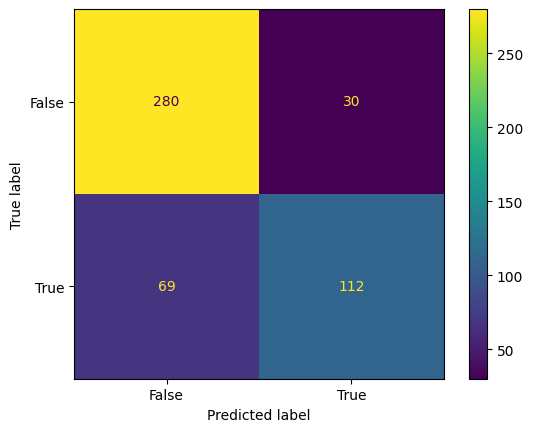

Model Performance: 

accuracy = 79.84%.
recall = 61.88%.
precision = 78.87%.
f1_score = 69.35%.
The tuned model with grid search had an improvement of 1.29%. respect the base model
The tuned model with grid search had an improvement of 0.77%. respect the tuned  model with random search


In [55]:
#Computing the tuned model accuracy                                 
gb_grid_metrics = evaluate(gb_final, X_val100, y_val100,conf_matrix=True)

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the base model'
                        .format( 100 * (gb_grid_metrics[0] - gb_base_metrics[0]) / gb_base_metrics[0]))

print('The tuned model with grid search had an improvement of {:0.2f}%. respect the tuned  model with random search'
                        .format( 100 * (gb_grid_metrics[0] - gb_random_metrics[0]) / gb_random_metrics[0]))

### Support Vector Machines (SVM)

In [16]:
svmodel = SVC(
    random_state= random_seed
)

print('Parameters currently in use:\n')
pprint(svmodel.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [17]:
svmodel.fit(X = X_train100, y = y_train100)
evaluate(svmodel, X_val100, y_val100)

Model Performance
Accuracy = 68.64%.


0.6863543788187373

#### Grid Search w/ Cross Validation

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf']
    }

svc_final = GridSearchCV(
    estimator = SVC(random_state=random_seed),
    param_distributions = param_grid,
    n_iter = 100,
    cv = 3, 
    verbose = 3, 
    random_state = random_seed, 
    n_jobs = -1
)

svc_final.fit(X_train100, y_train100)

In [25]:
svc_final.best_params_

NameError: name 'svc_final' is not defined

##### Save and load the model

In [24]:
#pickle.dump(svc_final, open('Models/svc_final.pkl', 'wb'))
svc_final = pickle.load(open('Models/svc_final.pkl', 'rb'))

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['linear', 'poly', 'rbf']},
                   random_state=42, verbose=3)

## Evalution Models

| Models              | Test Accuracy | Test Recall | Test Precision | F1 Score |
|---------------------|---------------|-------------|----------------|----------|
| Logistic Regression |               |             |                |          |
| Random Forest       |               |             |                |          |
| K-NN                |               |             |                |          |
| Orazio              |               |             |                |          |

## Unsupervised models
Unsupervised learning, also known as unsupervised machine learning, uses machine learning algorithms to analyze and cluster unlabeled datasets. These algorithms discover hidden patterns or data groupings without the need for human intervention. Its ability to discover similarities and differences in information make it the ideal solution for exploratory data analysis, cross-selling strategies, customer segmentation, and image recognition.There are two main unsupervised learning problems: 

- **Clustering**

Unsupervised learning is mainly used in clustering analysis.

Clustering analysis is a grouping effort in which the members of a group (i.e., a cluster) are more similar to each other than the members of the other clusters.
There are many different clustering methods available. They usually utilize a type of similarity measure based on selected metrics such as Euclidean or probabilistic distance. Bioinformatic sequence analysis, genetic clustering, pattern mining, and object recognition are some of the clustering problems that may be tackled with the unsupervised learning approach.

- **Dimensionality Reduction**

Another use case of unsupervised learning is dimensionality reduction. Dimensionality is equivalent to the number of features used in a dataset. In some datasets, you may find hundreds of potential features stored in individual columns. In most of these datasets, several of these columns are highly correlated. Therefore, we should either select the best ones, i.e., feature selection, or extract new features combining the existing ones, i.e., feature extraction. This is where unsupervised learning comes into play. Dimensionality reduction methods help us create neater and cleaner models that are free of noise and unnecessary features.


## Data Preprocessing

In [18]:
df_w100 = pd.DataFrame(water100, columns = water.columns)
df_w100=df_w100.drop(columns='Potability')
df_w100.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.003078,0.259195,-0.139471,0.112415,0.961017,1.708954,-1.180651,1.306187,-1.286298
1,-2.289378,-2.036414,-0.385987,-0.307694,0.021560,2.062575,0.270597,-0.638440,0.684218
2,0.692826,0.847665,-0.240047,1.360594,0.021560,-0.094032,0.781117,0.001549,-1.167365
3,0.840908,0.547651,0.000493,0.592008,0.639206,-0.778830,1.255134,2.152910,0.848412
4,1.368526,-0.464429,-0.460249,-0.363698,-0.654379,-0.343939,-0.824357,-2.181556,0.138786


In [19]:
df_w50 = pd.DataFrame(water50, columns = water.columns)
df_w50=df_w50.drop(columns='Potability')
df_w50.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.000559,0.260496,-0.135371,0.111608,0.918918,1.730636,-1.175663,1.300083,-1.299112
1,-2.212632,-2.047015,-0.382625,-0.308468,0.026220,2.089204,0.270464,-0.650714,0.681614
2,0.666458,0.852017,-0.236248,1.359694,0.026220,-0.097573,0.779182,-0.008695,-1.179564
3,0.809420,0.550448,0.005013,0.591165,0.613124,-0.791950,1.251527,2.149493,0.846659
4,1.318795,-0.466880,-0.457109,-0.364468,-0.616076,-0.350976,-0.820627,-2.198727,0.133356


## Dimensionality Reduction models
The Dimensionality Reduction models that we chose are the following:
- **PCA**
- **?**

### **Principal Component Analysis**
Principal component analysis (PCA) is a popular technique for analyzing large datasets containing a high number of dimensions/features per observation, increasing the interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data. 

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

In [45]:
# Applying PCA function 

pca = PCA(n_components = 2)

df_w100_pca = pca.fit_transform(df_w100)

explained_variance = pca.explained_variance_ratio_


In [46]:
pca_df_w100 = pd.DataFrame(data = df_w100_pca
             , columns = ['principal component 1', 'principal component 2'])

In [48]:
print('Explained variation per principal component: {}'.format(explained_variance))

Explained variation per principal component: [0.13338887 0.12630124]


Text(0.5, 1.0, 'Principal Component Analysis of Water Potability Dataset')

<Figure size 640x480 with 0 Axes>

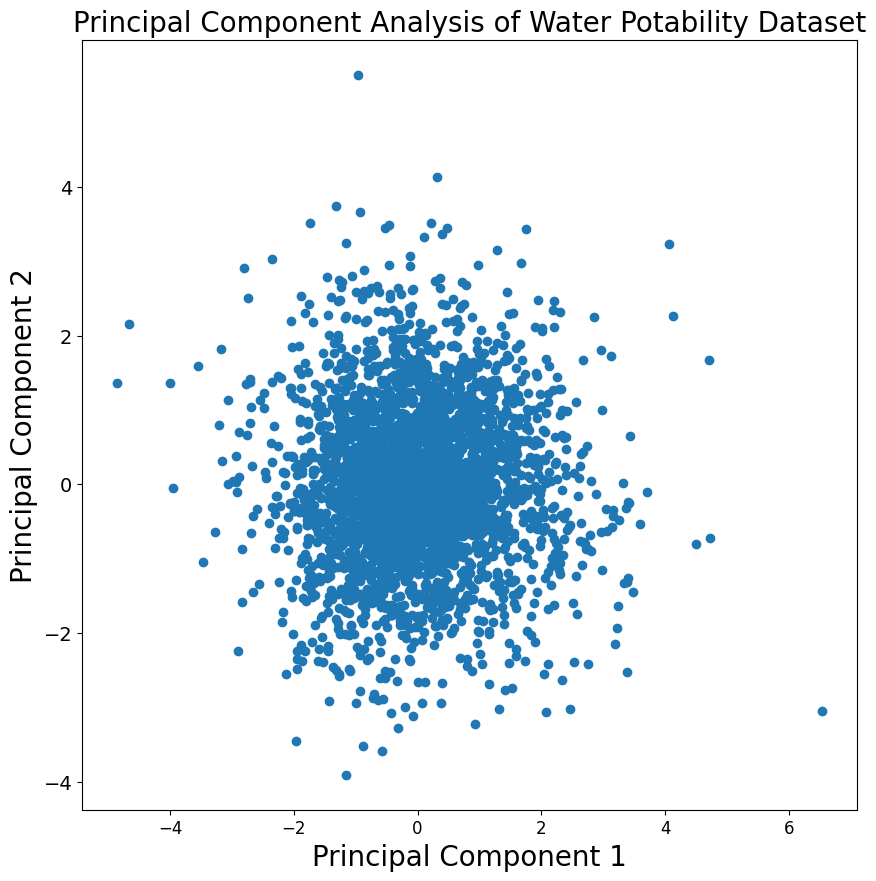

In [53]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.scatter(x=pca_df_w100['principal component 1'],y=pca_df_w100['principal component 2'])
plt.title("Principal Component Analysis of Water Potability Dataset",fontsize=20)

## Clustering models
The Clustering models that we chose are the following:
- **K-Means**
- **DBSCAN**


### **K-Means**
K-means is one of the most widely used and best performing clustering algorithms. Despite this, it is a very simple algorithm to implement and use.

K-means is based on so-called centroids. The centroid is a point belonging to the feature space that averages the distances between all the data belonging to the cluster associated with it. It thus represents a kind of barycenter of the cluster and in general, precisely because of its characteristics, is not one of the points in the dataset.

Source: [link](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

#### K-Means on dataset water100

Text(0, 0.5, 'Sum Squared Distance')

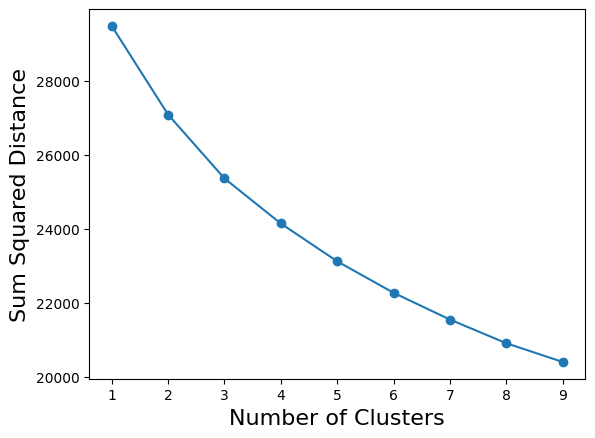

In [14]:
#To check the optimal possible number of clusters we will use elbow method
sdq = {}
for k in range(1, 10):
                # n_init is the number of times the k-means algorithm is run with different centroid seeds
    km = KMeans(n_init="auto",
                # Init random assign the centroids randomly
                init="random", 
                # n_clusters define the number of clusters to research at each iteration
                n_clusters=k
                )

    km.fit(df_w100)
    # Inertia contains Sum of squared distances of samples to their closest cluster center,
    #  weighted by the sample weights if provided.
    sdq[k] = km.inertia_

# Plotting the results
plt.plot(list(sdq.keys()), list(sdq.values()), marker="o")
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Sum Squared Distance", fontsize=16)

As we can see it doesn't seem to be the presence of clusters, since is not present a clear elbow in the chart

#### K-Means on dataset water50

Text(0, 0.5, 'Sum Squared Distance')

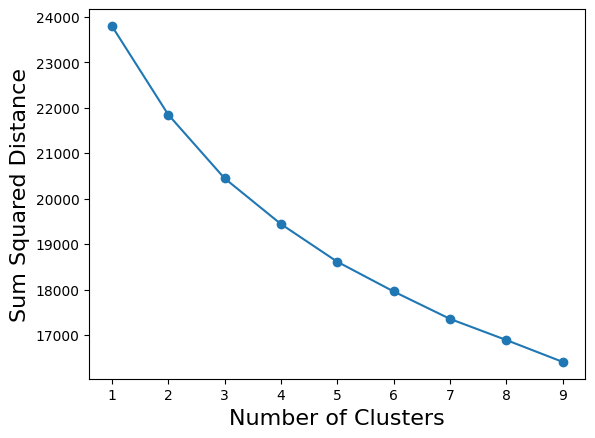

In [17]:
#To check the optimal possible number of clusters we will use elbow method
sdq = {}
for k in range(1, 10):
                # n_init is the number of times the k-means algorithm is run with different centroid seeds
    km = KMeans(n_init="auto",
                # Init random assign the centroids randomly
                init="random", 
                # n_clusters define the number of clusters to research at each iteration
                n_clusters=k
                )

    km.fit(df_w50)
    # Inertia contains Sum of squared distances of samples to their closest cluster center,
    #  weighted by the sample weights if provided.
    sdq[k] = km.inertia_

# Plotting the results
plt.plot(list(sdq.keys()), list(sdq.values()), marker="o")
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Sum Squared Distance", fontsize=16)